# Система уравнений и численная схема

Система уравнений мелкой воды:  

$\eta_t + ((\eta + x) u)_x = 0,$  
$u_t + \eta_x + (\frac{u^2}{2})_x= 0$

Пробуем численно решить систему с помощью дивергентной схемы:  

 $h (\eta_n^{m+1} - \eta_n^{m}) + \tau ((N_{n+1/2}^{m+1/2} + x_{n+1/2}) U_{n+1/2}^{m+1/2} -
  (N_{n-1/2}^{m+1/2} + x_{n-1/2}) U_{n-1/2}^{m+1/2}) = 0,$  
 
 $h (u_n^{m+1} - u_n^{m}) + \tau (N_{n+1/2}^{m+1/2} - N_{n-1/2}^{m+1/2} +
  \frac{(U_{n+1/2}^{m+1/2})^2 - (U_{n-1/2}^{m+1/2})^2}{2}) = 0,$  

Величины $N_{n+1/2}^{m+1/2}$ и $U_{n+1/2}^{m+1/2}$ найдем из следующих соотношений:  

 $N_{n+1/2}^{m+1/2} = $  
 $U_{n+1/2}^{m+1/2} = $
 
 !!!To do - написать схемы на границах, в половинных точках; написать про дно!!!

# Код

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def solve_eq(h, tau, x_range, t_range, u0, eta0):
    """Функция считает схему, указанную выше.
    
        u0, eta0 - начальные условия
        x_range - пара чисел, задающая границы изменения по x
        t_range - пара чисел, задающая границы изменения по t
        h - шаг по x
        tau - шаг по t
        
       Схема явная - каждый следующий шаг по времени вычисляется из предыдущего"""
    
    # задаём сетку
    x_range = sorted(x_range)
    x = np.arange(x_range[0], x_range[1] + h, h)
    t_range = sorted(t_range)
    t = np.arange(t_range[0], t_range[1] + tau, tau)
    N = x.size
    M = t.size
    
    # создаём сеточные функции и задаём начальные условия с учётом дна - 
    # ищем максимальную по x точку, в которой возвышение меньше дна,
    # во всех точках левее полагаем возвышение равным дну, а скорость - нулю
    u = np.zeros((M, N))
    u[0] = u0
    eta = np.zeros((M, N))
    eta[0] = eta0
    
    index = -1
    for i, v in enumerate((eta[0] + x)[::-1]):
        if np.abs(v) < h:
            index = i
            break
    index = len(x) - index
    if 0 < index < len(x):
        eta[0][:index] = -x[:index]
        u[0][:index] = np.zeros(index)
    
    # Вспомогательные конструкции
    f = tau/h
    f2 = f / 2
    x2 = (x + np.roll(x, -1)) / 2
    eta_l = None
    eta_r = None
    eta2 = None
    u_l = None
    u_r = None
    u_2 = None
    
    # находим u
    for m in range(0, M-1):
        
        # шаг-"предиктор"
        eta_l = (eta[m]                                                                 -
                 (tau/2 + f2*(np.roll(eta[m], -1) - 2*eta[m] - x)) * u[m]               -
                 f2*(eta[m] + x)                                   * np.roll(u[m], -1))
        eta_l[-1] = 0
        
        eta_r = (eta[m]                                                                 -
                 (tau/2 + f2*(-np.roll(eta[m], 1) + 2*eta[m] + x)) * u[m]               -
                 f2*(eta[m] + x)                                   * np.roll(u[m], 1))
        eta_r[0] = 0
        
        eta2 = (eta_l + np.roll(eta_r, -1)) / 2
        
        u_l = ((1 - f2*(np.roll(u[m], -1) - u[m])) * u[m] -
               f2*(np.roll(eta[m], -1) - eta[m]))
        u_l[-1] = 0
        
        u_r = ((1 - f2*(-np.roll(u[m], 1) + u[m])) * u[m] -
               f2*(np.roll(-eta[m], 1) + eta[m]))
        u_r[0] = 0
        
        u2 = (u_l + np.roll(u_r, -1)) / 2
        
        # шаг-"корректор"
        eta[m+1] = (eta[m]                            -
                    f * (eta2 + x2) * u2              +
                    f * np.roll((eta2 + x2) * u2, 1))
        
        u[m+1] = (u[m]                                      -
                  f * (eta2 + np.power(u2, 2)/2)            +
                  f * np.roll(eta2 + np.power(u2, 2)/2, 1))
        
        # Задаём значения на правой границе
        eta[m+1][N-1] = (eta[m][N-1] - 
                         (tau + f*(2*eta[m][N-1] - eta[m][N-2] + x[N-1])) * u[m][N-1] +
                         f*(eta[m][N-1] + x[N-1])                         * u[m][N-2])
        
        u[m+1][N-1] = ((1 - f*(u[m][N-1] - u[m][N-2])) * u[m][N-1] -
                       f*(eta[m][N-1] - eta[m][N-2]))
        
        # Задаём значения на левой границе
        eta[m+1][0] = (eta[m][0]                                             - 
                       (tau + f*(-2*eta[m][0] + eta[m][1] - x[0])) * u[m][0] -
                       f*(eta[m][0] + x[0])                        * u[m][1])
        
        u[m+1][0] = ((1 - f*(u[m][1] - u[m][0])) * u[m][0] -
                     f*(eta[m][1] - eta[m][0]))
        
        # Поправляем возвышение свободной поверхности и скорость с учётом дна - 
        # ищем максимальную по x точку, в которой возвышение меньше дна,
        # во всех точках левее полагаем возвышение равным дну, а скорость - нулю
        index = -1
        for i, v in enumerate((eta[m+1] + x)[::-1]):
            if np.abs(v) < h:
                index = i
                break
        index = len(x) - index
        if 0 < index < len(x):
            eta[m+1][:index] = -x[:index]
            u[m+1][:index] = np.zeros(index)
    
    return eta, u

In [7]:
# задаём сетку
h = 0.01
tau = 0.0005
# интервал по пространству
x_range = (-0.7, 10.1)
x = np.arange(x_range[0], x_range[1] + h, h)
# интервал по времени
t_range = (0.0, 5.1)
t = np.arange(t_range[0], t_range[1] + tau, tau)

# задаём начальные условия
u0 = np.zeros(len(x))
#u0 = np.exp(-np.power((x-3.5)/0.3, 2))
#u0 = -np.ones(len(x))
eta0 = 0.5 * np.exp(-np.power((x-2.5)/0.3, 2))

# численно решаем уравнение
eta_num, u_num = solve_eq(h, tau, x_range, t_range, u0, eta0)

# Строим графики

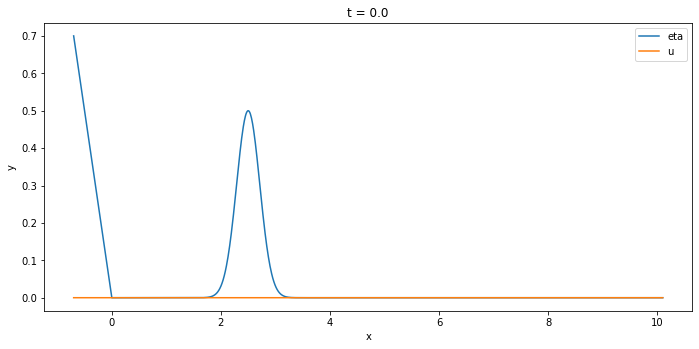

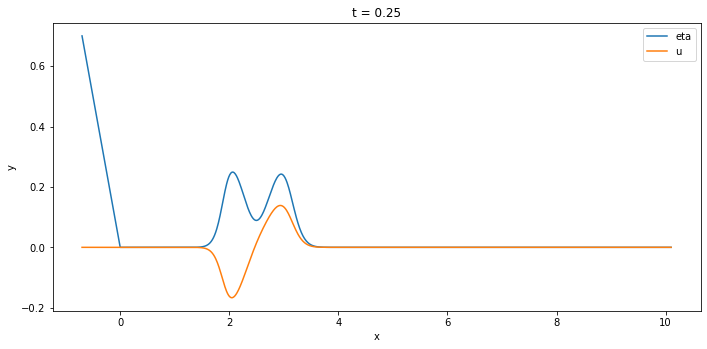

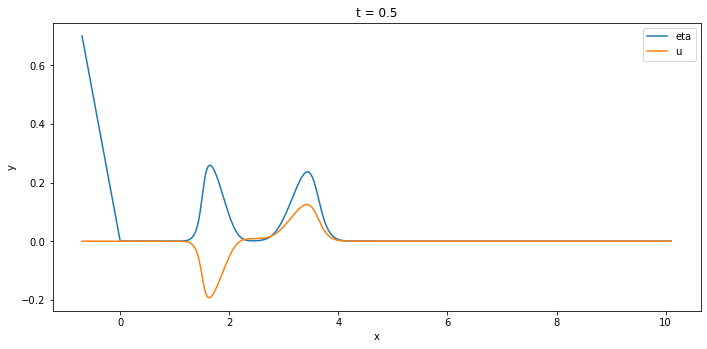

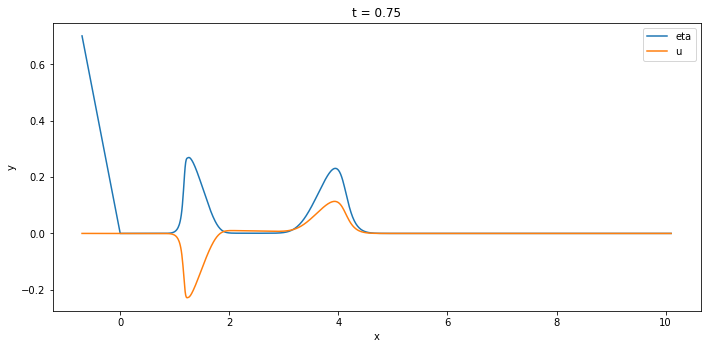

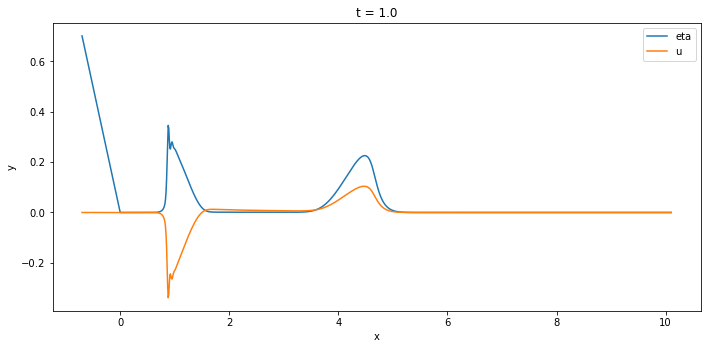

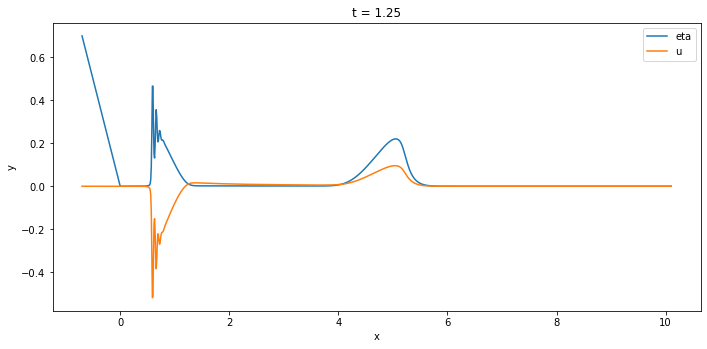

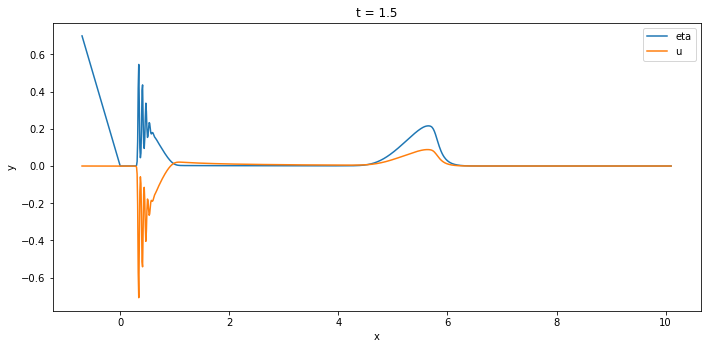

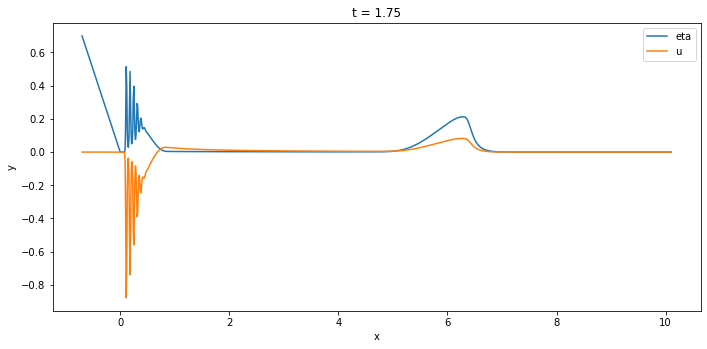

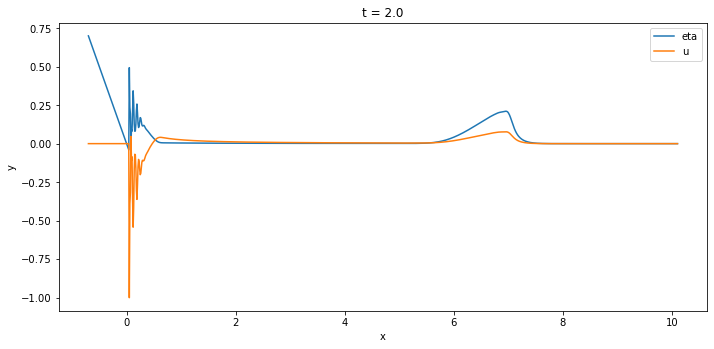

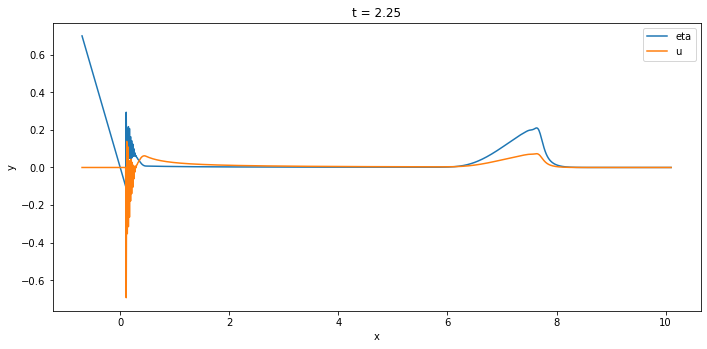

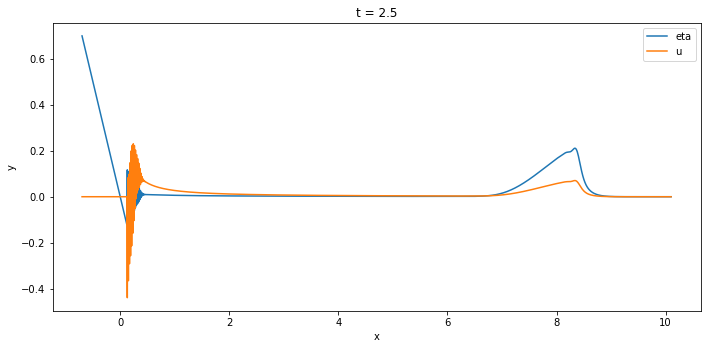

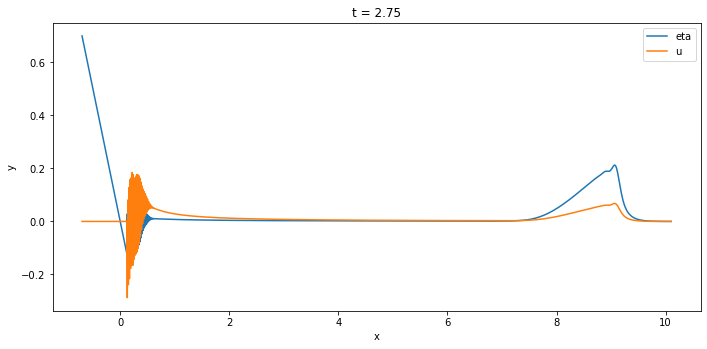

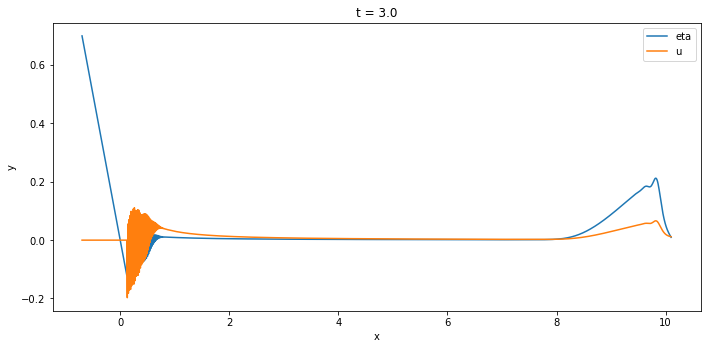

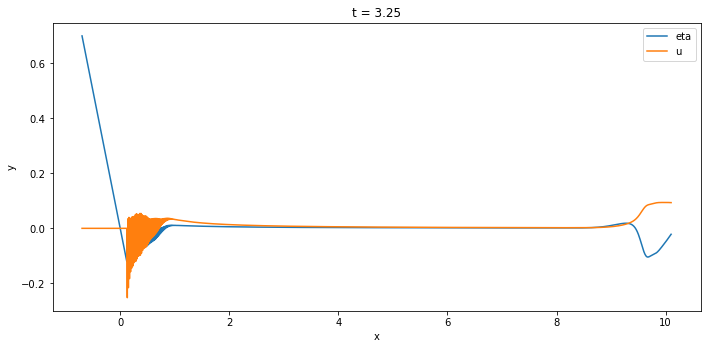

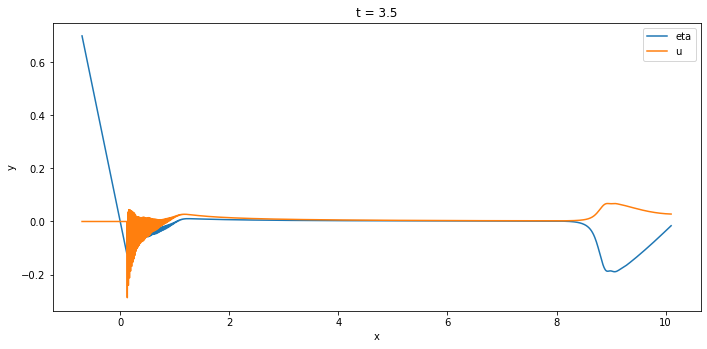

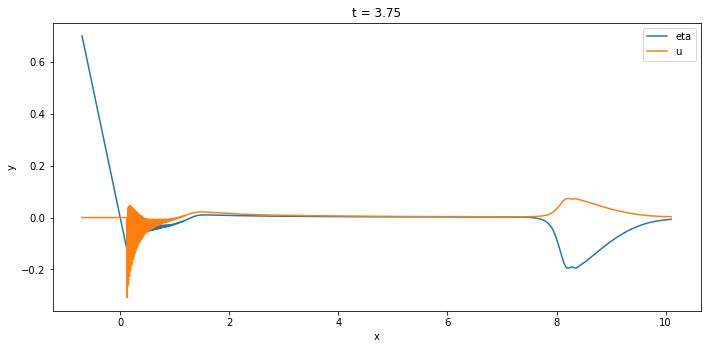

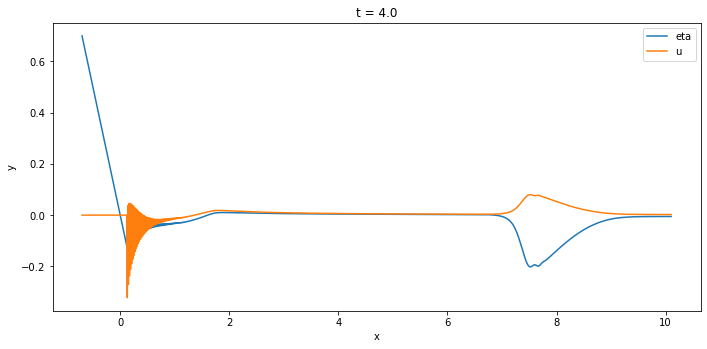

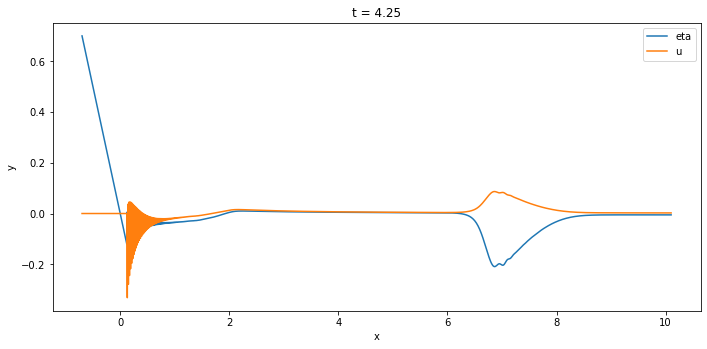

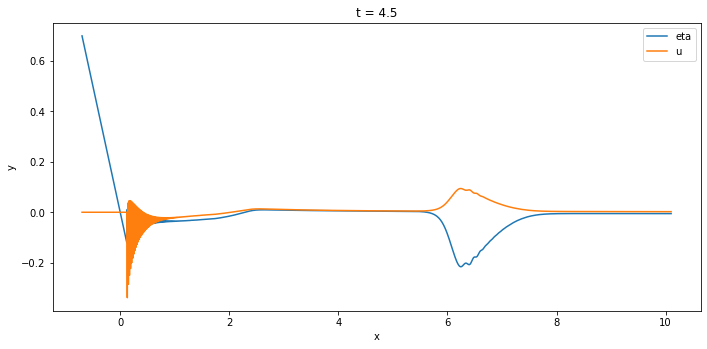

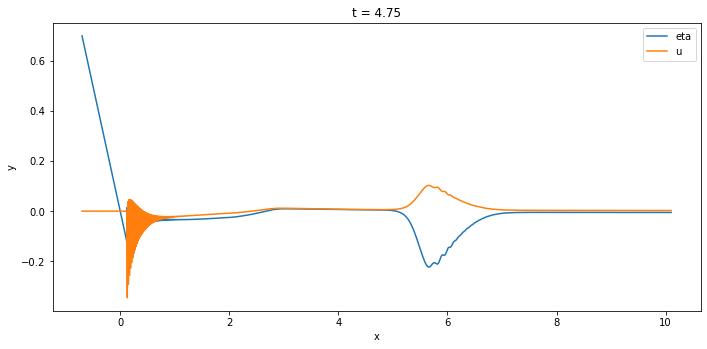

In [8]:
# строим графики;
# временной интервал между "кадрами"
time_step = 0.25
# до какого времени смотрим решение
final_time = 5.0

i = 0
while (i*time_step)/tau < final_time/tau:
    fig = plt.figure()
    axes = fig.add_axes([0.0, 2.0, 1.5, 1.0])
    axes.plot(x, eta_num[round((i*time_step)/tau)], label='eta')
    axes.plot(x, u_num[round((i*time_step)/tau)], label='u')
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    axes.set_title('t = ' + str(t_range[0] + i*time_step))
    axes.legend(loc=0)
    i += 1